For XArrays -> [Tutorial](https://www.youtube.com/watch?v=1a2yqIltVT8&t=698s)

In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from datetime import datetime

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

from sklearn.preprocessing import MinMaxScaler

ds = xr.open_dataset('ERA5_Data/2022to2024_SA.nc')


In [3]:
ds_combine = ds.sel(expver=1).combine_first(ds.sel(expver=5))
ds_combine.load()

<xarray.Dataset> Size: 2GB
Dimensions:    (time: 20337, latitude: 34, longitude: 71)
Coordinates:
  * time       (time) datetime64[ns] 163kB 2022-01-01 ... 2024-04-27T08:00:00
  * longitude  (longitude) float32 284B 15.56 15.81 16.06 ... 32.56 32.81 33.06
  * latitude   (latitude) float32 136B -26.89 -27.14 -27.39 ... -34.89 -35.14
Data variables:
    u10        (time, latitude, longitude) float64 393MB -1.792 ... -0.3327
    v10        (time, latitude, longitude) float64 393MB 3.15 2.202 ... 6.066
    t2m        (time, latitude, longitude) float64 393MB 287.9 286.7 ... 290.3
    sp         (time, latitude, longitude) float64 393MB 9.664e+04 ... 1.029e+05
Attributes:
    Conventions:  CF-1.6
    history:      2024-05-09 14:16:01 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [4]:
ds_wind = ds_combine.assign(ws = np.sqrt(ds_combine.u10**2 + ds_combine.v10**2))
ds_wind = ds_wind.assign(wd = np.arctan2(ds_combine.v10, ds_combine.u10) * 180 / np.pi)

In [4]:
lon = ds_wind.longitude
lat = ds_wind.latitude

WS = ds_wind.ws
wind_u = ds_wind.u10
wind_v = ds_wind.v10

## Maps

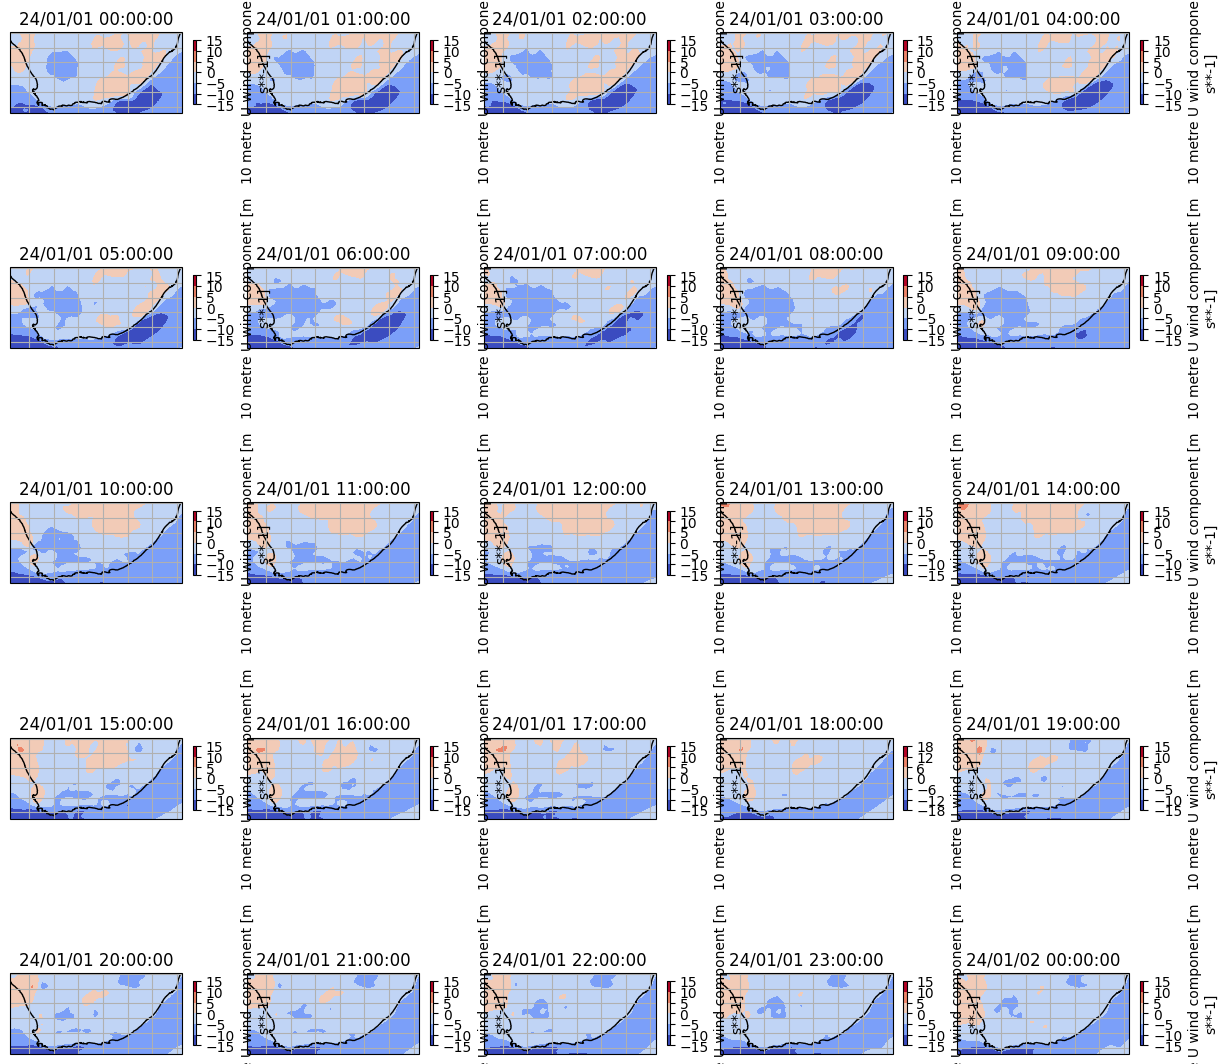

In [5]:
seed_start = 0
num_plots = 5  

fig, axs = plt.subplots(num_plots, num_plots, figsize=(15, 15),
                        subplot_kw={'projection': ccrs.PlateCarree()})

axs = axs.flatten()

for i, ax in enumerate(axs):
    seed = seed_start + i
    
    ds_combine['u10'].isel(time=seed).plot.contourf(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm',
                                                     cbar_kwargs={'shrink': 0.3})  
    
    ax.coastlines()
    ax.gridlines()

    date_time = ds.time[seed].item() / 1e9
    date_time = datetime.utcfromtimestamp(date_time)
    date_time = date_time.strftime("%y/%m/%d %H:%M:%S") 
    
    ax.set_title(f'{date_time}')

plt.subplots_adjust(hspace=0.1, wspace=0.1)

plt.show()


## Wind speed and direction

In [6]:
seed = 0    

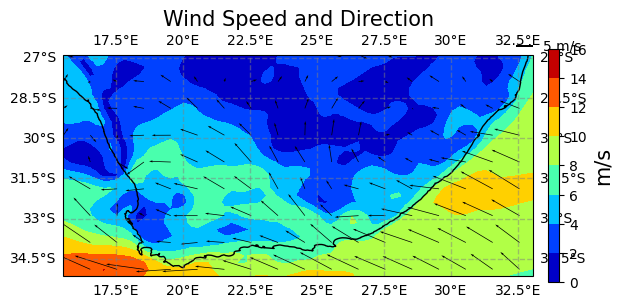

In [7]:
seed += 10
skip = 4

Projection = ccrs.PlateCarree()

ax = plt.axes(projection=Projection)

cf = plt.contourf(lon,lat,WS[seed,:,:], cmap='jet')

Q = plt.quiver(lon[::skip],lat[::skip],wind_u[seed,::skip,::skip],wind_v[5,::skip,::skip], scale_units='xy', scale=8, width=0.0015)

qk = plt.quiverkey(Q, 
              1, 1.04,                  
               5,str(5)+' m/s',   
               labelpos='E',                
               coordinates='axes'
               )

cb = plt.colorbar(cf, fraction=0.0235, pad=0.03 )
cb.set_label('m/s',  fontsize=15)

ax.coastlines()
gl = ax.gridlines(crs=Projection, draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')

ax.set_title('Wind Speed and Direction', fontsize=15)

plt.show()

In [8]:
im = ax.imshow(WS[seed,:,:], cmap='jet', extent=(lon.min(), lon.max(), lat.min(), lat.max()), transform=Projection)


## ERA vs OWM

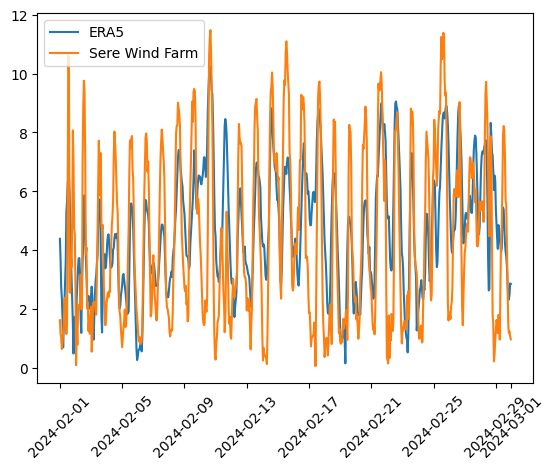

In [10]:
date = '2024-02'

df = pd.read_csv('ERA5_Data\Sere Wind Farm_hourly_OWM.csv', index_col='timestamp', parse_dates=True)
era = ds_wind['ws'].sel(latitude=-31.7500, longitude=18.0833, method='nearest').values
time = ds_wind['time'].values
df_ERA = pd.DataFrame(era, index=time, columns=['ERA5'])
plt.plot(df_ERA.loc[date], label = 'ERA5')
plt.plot(df.loc[date]['wind_speed'], label = 'Sere Wind Farm')

plt.xticks(rotation=45)
plt.legend()
plt.show()

## Input to models

In [ ]:
def windows(ds, window_size):
    X, y = [], []
    for i in range(ds.shape[0] - 2):
        feature = ds[i:i + window_size].values
        target = ds[i + window_size].values
        X.append(feature)
        y.append(target)

    return np.array(X), np.array(y)


In [ ]:
window_size = 2
ds_ = ds_wind['ws']

lon = ds_wind.longitude
lat = ds_wind.latitude

X, y = windows(ds_, window_size)

print('Features: ', np.array(X).shape,'Targets: ', np.array(y).shape)

Features:  (2815, 2, 34, 71) Targets:  (2815, 34, 71)


In [ ]:
X.max(), y.max()

(21.352293287329466, 21.352293287329466)

C:\Users\23603526\AppData\Local\Temp\ipykernel_13480\1754873261.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


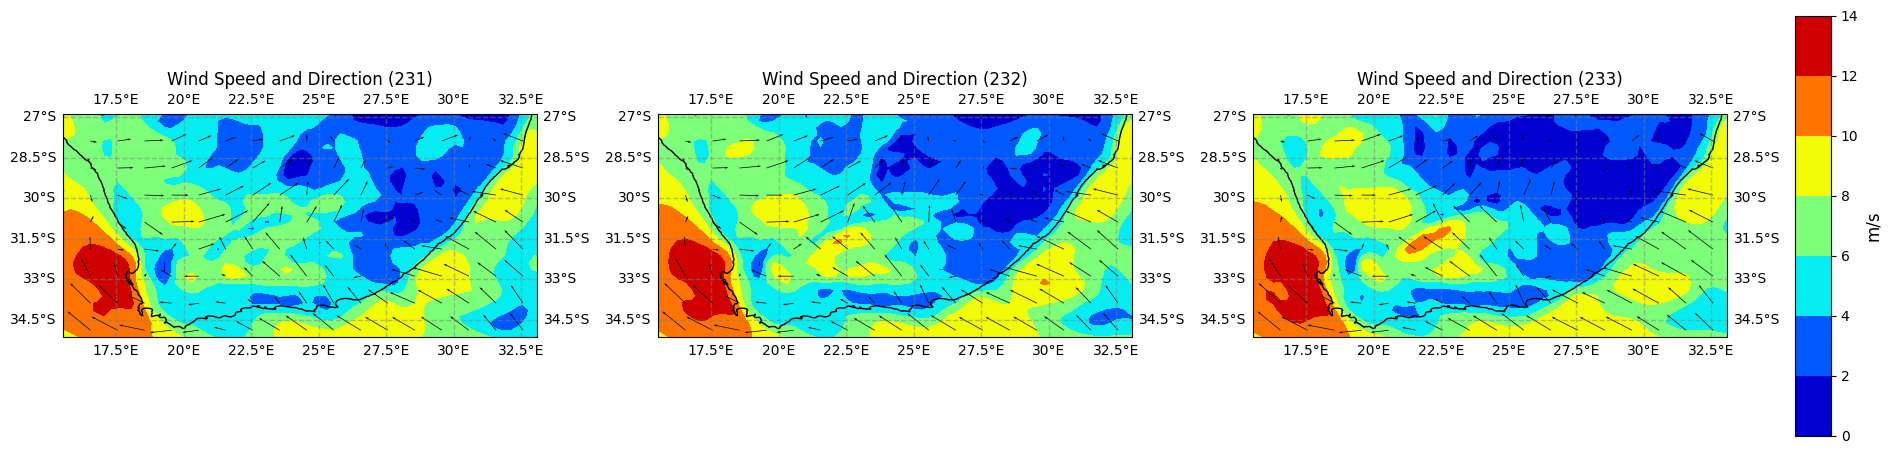

In [ ]:
seed += 10
skip = 4
Projection = ccrs.PlateCarree()

fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': Projection})

for i, ax in enumerate(axs):
    cf = ax.contourf(lon, lat, WS[seed + i, :, :], cmap='jet')
    ax.quiver(lon[::skip], lat[::skip], wind_u[seed + i, ::skip, ::skip], wind_v[5, ::skip, ::skip],
              scale_units='xy', scale=8, width=0.0015)
    ax.coastlines()
    gl = ax.gridlines(crs=Projection, draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    ax.set_title(f'Wind Speed and Direction ({seed + i})', fontsize=12)

# Add colorbar
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cb = plt.colorbar(cf, cax=cbar_ax)
cb.set_label('m/s', fontsize=12)

plt.tight_layout()
plt.show()


In [1]:
import xarray as xr

# Load the three input files
# ds1 = xr.open_dataset('ERA5_Data/2022_SouthAfrica.nc')
# ds2 = xr.open_dataset('ERA5_Data/2023_SouthAfrica.nc')
# ds3 = xr.open_dataset('ERA5_Data/2024_SouthAfrica.nc')

# # Combine the datasets along a common dimension (e.g., time, latitude, longitude)
# combined_ds = xr.concat([ds1, ds2, ds3], dim='time')  # Adjust the dimension name as needed

# # Save the combined dataset to a new file
# combined_ds.to_netcdf('2022to2024_SA.nc')

# # Close the datasets
# ds1.close()
# ds2.close()
# ds3.close()


c:\Users\23603526\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
